<a href="https://colab.research.google.com/github/tamtran4869/marketing_effectiveness_analysis/blob/main/Causal_inference_econml_dowhy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uplift modelling with econml and dowhy

Like `causalml` packages, `econml` provides functions to estimate the effect of treatments (uplift values). It combines with `dowhy` to provide functions for graph and sentiment analysis to refute models.

This notebook includes 2 types of causal effect estimators: Double Machine Learning (DML) and Doubly Robust Learning (DRL) to answer a marketing question: Who should be offered promotions? by computing treatment effect (TE).

## Install and import libraries

In [1]:
%%capture
!pip install econml[dowhy]
!pip install cdt
!pip install scikit-uplift
#!pip install econml

In [2]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
from sklift.viz import plot_uplift_curve

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
import shap

# Generic ML imports
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.dr import ForestDRLearner
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt

%matplotlib inline

## Load data

The data includes:

- Variables x: recency, history, user_discount, used_bogo, zip_code, is_referral, channel
- An outcome variable y: conversion
- A condition/treatment variable t: offer

The details of the dataset can be found https://www.kaggle.com/datasets/davinwijaya/customer-retention

This notebook addresses only 2 options for the offer (0 = No Offer and 1 = Buy One Get One).

In [3]:
# Upload data
url='https://drive.google.com/file/d/1vjqiiAWpBv6IO0Fd-Rz8BTgXrIZy1Q2w/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df = df[df['offer'] != 'Discount']
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1


In [ ]:
# Checl data type and na values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42693 entries, 0 to 63998
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        42693 non-null  int64  
 1   history        42693 non-null  float64
 2   used_discount  42693 non-null  int64  
 3   used_bogo      42693 non-null  int64  
 4   zip_code       42693 non-null  object 
 5   is_referral    42693 non-null  int64  
 6   channel        42693 non-null  object 
 7   offer          42693 non-null  object 
 8   conversion     42693 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.3+ MB


In [ ]:
#Check values of numerical variables
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000
mean,5.758789,241.711212,0.551074,0.548872,0.502612,0.128827
std,3.504745,254.040262,0.497390,0.497612,0.499999,0.335012
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.160000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,158.460000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,326.050000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Check values of categorical variables
df.describe(include='object')

,zip_code,channel,offer
count,42693,42693,42693
unique,3,3,2
top,Surburban,Phone,Buy One Get One
freq,19275,18781,21387


## Preprocess

- Convert values of `offer`
- Encode categorical variables

In [7]:
# Convert treatment values to 0 for No Offer and 1 for Buy One Get One
df['offer'].replace(['No Offer', 'Buy One Get One'],
                        [0,1], inplace=True)
# Encode categorical variables
dum = pd.get_dummies(df[['zip_code','channel']])
df = pd.concat([df.drop(['zip_code','channel'],axis =1),dum.drop(['zip_code_Urban',	'channel_Multichannel'],axis = 1)],axis =1)

- Assign data to variables

In [ ]:
# Define estimator inputs
y = df["conversion"]  # outcome of interest
t = df["offer"]  # intervention, or treatment
x = df.drop(columns=["conversion", "offer"])

- Split train and test data

In [ ]:
# Split data into train and test
n_half = round(0.20 * x.shape[0])
df_train, df_test = df[n_half:],df[:n_half]
#w_train, w_test = w[n_half:], w[:n_half]
x_train, x_test = x[n_half:], x[:n_half]
t_train, t_test = t[n_half:], t[:n_half]
y_train, y_test = y[n_half:], y[:n_half]

## Causal estimate - uplift modelling

DML and DRL are methods for treatment effect estimation just like meta-learners, tree-based methods. However, DML has a different approach and DRL has the same approach but is more robust.

We have:
- X: Features
- W: confounders (sometimes it is combined with X if we are not interested in particular X features)
- T: treatments/interventions/actions
- Y: outcomes


### DML

*Double machine learning method:*
- Step 1: Fit in a model: input X, W + output Y (actual outcome) -> predicted outcome Y_hat
- Step 2: Fit in a model: input X, W + output T (actual treatment) -> predicted treatment T_hat (it is propensity score)
- Step 3: Fit in a model: input (T-T_hat) + output (Y-Y_hat) -> treatment effect

With (Y-Y_hat) and (T-T_hat) we remove the effects of W and X on outcome Y and treatment T then the remaining effect is purely the treatment effect.

Since the outcome is binary, CausalForestDML is chosen.

In [ ]:
SEED = 24
# Define function for step1 and step 2 (first_stage)
first_stage = lambda model,scoring: GridSearchCV(
                estimator = model,
                param_grid={
                        'max_depth': [3, None],
                        'n_estimators': (50,100),
                        'random_state': [SEED]
                    }, cv=5, n_jobs=-1, scoring= scoring
                )


In [ ]:
# Train EconML model
est_DML = CausalForestDML(
    model_y=first_stage(XGBRegressor(),'neg_mean_squared_error'),
    model_t=first_stage(XGBRegressor(),'neg_mean_squared_error'))


#est_DML.fit(y_train, t_train, X=x_train, inference="blb")
# Get treatment effect and its confidence interval
#pred_DML = est_DML.effect(x_test)
#pred_interval_DML = est_DML.effect_interval(x_test)

A process of causal inference through `dowhy` has 4 main steps:
- Model (CausalModel or graph): provide a causal graph based on domain knowledge or `dowhy` can provide one.
- Identify (identify_effect): approach different ways to find variables we can use to estimate effects from the data.
- Estimate (estimate_effect): estimate TE
- Refute (refute_estimate): we do not have ground-truth data of treatment effect (we only have actual data of one scenario) so to check the robustness of models, we compute sentiment analysis. It transforms data into augmented data (by replacing an x variable, removing a subset, randomly assigning t, etc.) to see how the model reacts. The part is not included in this notebook.

In [ ]:
# fit through dowhy
est_dw_DML=est_DML.dowhy.fit(y_train, t_train, X=x_train, outcome_names=["conversion"], treatment_names=["offer"],
                     feature_names=list(x_train.columns), target_units=x_test,
                     inference="blb")

<Figure size 1000x800 with 0 Axes>

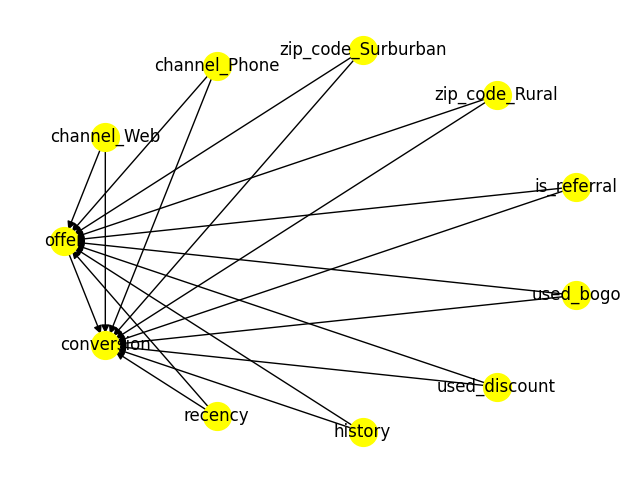

In [ ]:
# Visualize causal graph
plt.figure(figsize=(10,8))
est_dw_DML.view_model()

In [ ]:
# Identify the effects
identified_estimand = est_dw_DML.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[conversion|history,channel_Phone,is_referral,recency,zip_code_Surbu
d[offer]                                                                      

                                                         
rban,channel_Web,used_discount,used_bogo,zip_code_Rural])
                                                         
Estimand assumption 1, Unconfoundedness: If U→{offer} and U→conversion then P(conversion|offer,history,channel_Phone,is_referral,recency,zip_code_Surburban,channel_Web,used_discount,used_bogo,zip_code_Rural,U) = P(conversion|offer,history,channel_Phone,is_referral,recency,zip_code_Surburban,channel_Web,used_discount,used_bogo,zip_code_Rural)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In this case, the model uses backdoor approach to estimate causal effects.

Next, from predict treatment effect, we get policy by giving offers for person who have TE is greater than 0.

In [ ]:
# Get predicted treatment effects of test data
estimate_DML = est_dw_DML.estimate_
pred_DML = estimate_DML.cate_estimates
# Get policy based on TE prediction
policy_DML = pd.Series([0 if i <= 0 else 1 for i in pred_DML])
policy_DML.value_counts()

1    6378
0    2161
dtype: int64

### DRL

*Doubly robust learning method:*
- Step 1:
  - fit in a model with only users T=1: input X, W  + output Y -> predicted outcome Y_hat1
  - fit in a model with only users T=0: input X, W  + output Y -> predicted outcome Y_hat0

- Step 2: fit in a model: input X, W + output T (actual treatment) -> predicted treatment T_hat (it is propensity score)

- Step 3: compute doubly robust variables

DR = (Y_hat1 + (Y-Y_hat1) * T/T_hat) - (Y_hat0 + (Y-Y_hat0) * (1-T)/(1-T_hat))

- Step 4: fit a model: input X + output DR -> treatment effect

DRL normally belongs to meta-learners since it has the same approach including computing outcome Y of 2 scenarios and the weighted difference between them using propensity score.
The robust part is as long as either Y_hat or T_hat is accurate, the final model is correct.

*For example:*

We assume:
- Y_hat1, Y_hat0 are correct
- T_hat is not correct

-> The part before minus sign remains equal to Y_hat1 + 0*T/T_hat = Y_hat1. It cancels out the incorrect part T_hat. Same for the other part of the equation.

We assume:
- Y_hat1, Y_hat0 are not correct
- T_hat is correct

-> The part before minus sign becomes Y_hat1 + (Y - Y_hat1)*1/1 = Y. It helps cancel out a part of incorrect data Y_hat1 and Y_hat0.


In [ ]:
# Train EconML model
est_DRL = ForestDRLearner(
    model_propensity= first_stage(XGBClassifier(), 'f1'),
    model_regression= first_stage(XGBRegressor(),'neg_mean_squared_error'))
#est_DRL.fit(y_train, t_train, X=x_train, inference="blb")
# Get treatment effect and its confidence interval
#pred_DRL = est_DRL.effect(x_test)
#pred_interval_DRL = est_DRL.effect_interval(x_test)

In [ ]:
# fit through dowhy
est_dw_DRL=est_DRL.dowhy.fit(y_train, t_train, X=x_train, outcome_names=["conversion"], treatment_names=["offer"],
                     feature_names=list(x_train.columns), target_units=x_test,
                     inference="blb")

In [ ]:
# Identify effects
identified_estimand = est_dw_DRL.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[conversion|history,channel_Phone,is_referral,recency,zip_code_Surbu
d[offer]                                                                      

                                                         
rban,channel_Web,used_discount,used_bogo,zip_code_Rural])
                                                         
Estimand assumption 1, Unconfoundedness: If U→{offer} and U→conversion then P(conversion|offer,history,channel_Phone,is_referral,recency,zip_code_Surburban,channel_Web,used_discount,used_bogo,zip_code_Rural,U) = P(conversion|offer,history,channel_Phone,is_referral,recency,zip_code_Surburban,channel_Web,used_discount,used_bogo,zip_code_Rural)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Get TE predictions for test data
estimate_DRL = est_dw_DRL.estimate_
pred_DRL = estimate_DRL.cate_estimates
# Get policy
policy_DRL = pd.Series([0 if i <= 0 else 1 for i in pred_DRL])
policy_DRL.value_counts()

1    6316
0    2223
dtype: int64

### Comparation

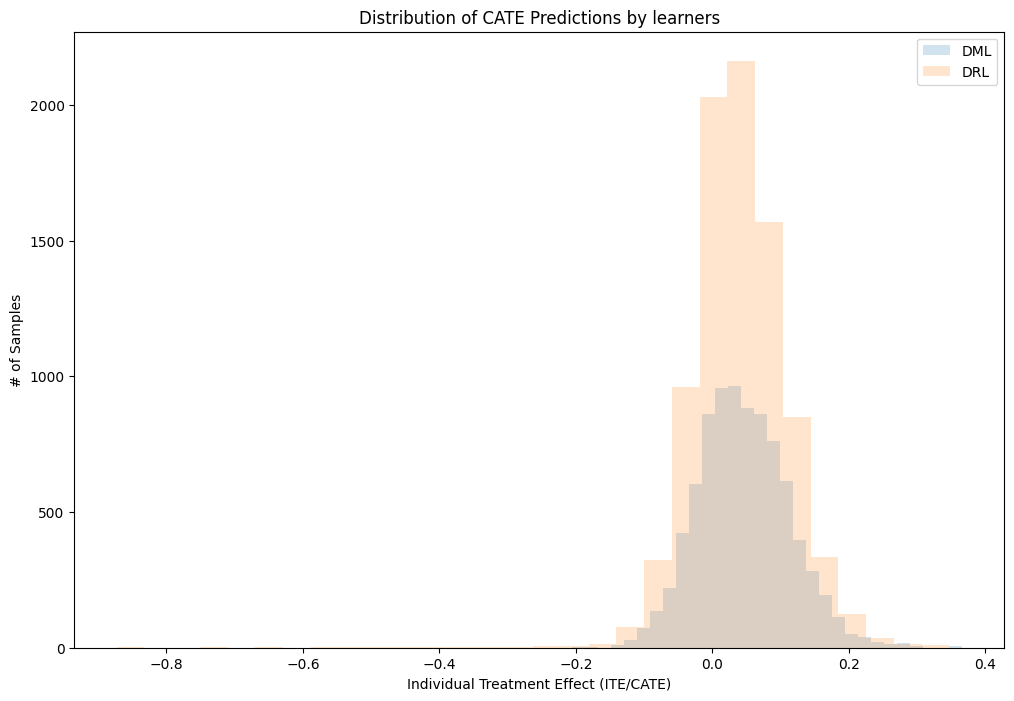

In [ ]:
# Distribution of treatment effects
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(pred_DML, alpha=alpha, bins=bins, label='DML')
plt.hist(pred_DRL, alpha=alpha, bins=bins, label='DRL')

plt.title('Distribution of CATE Predictions by learners')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()


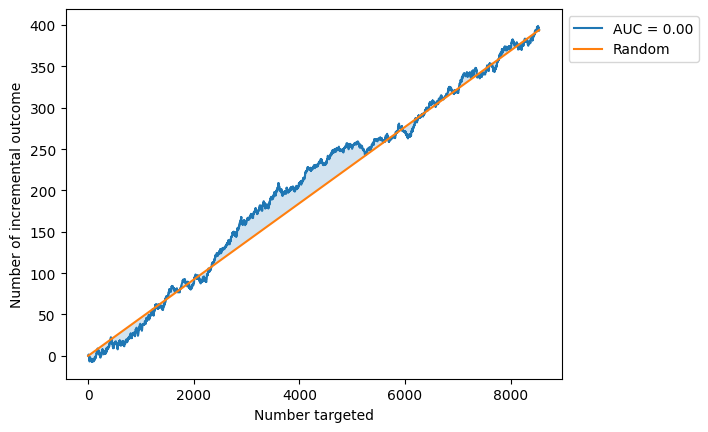

In [ ]:
# Uplift curve of DML
plot_uplift_curve(uplift = pred_DML, y_true = y_test, treatment = t_test,perfect = False)

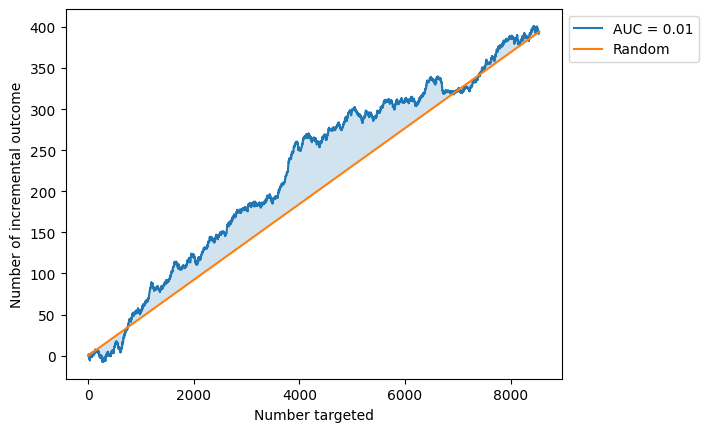

In [ ]:
#Uplift curve of DRL
plot_uplift_curve(uplift = pred_DRL, y_true = y_test, treatment = t_test,perfect = False)

It is clear that the DRL policy is better than random and the DML policy.

## Get cost and revenue involved
DRL policy gets us more conversions. Does it also get us more revenue? We need to consider cost and price as well.

Besides, DML and DRL, other policies are considered as well:
- ALL: Give offers for everyone.
- NONE: No one gets offers.
- ACTUAL: The actual used policy in the observed data.

In [ ]:
# Define revenue function
def rev_fn(cost_pct,price,policy,treatment,outcome):
  lst =[]
  po_same_actual = policy == treatment
  for pct in cost_pct:
    cost = pct*price
    rev = (price*outcome[po_same_actual]- cost*policy[po_same_actual])
    lst.append(np.mean(rev))
  return lst


Cost percentages 3% - 6% of the price are tested with value of a conversion (price) is 20.

In [ ]:
# Assign variables
cost_pct = [0.03,0.04,0.05,0.06]
policy_dic = {}
price = 20

policy_dic['ALL'] = rev_fn(cost_pct,price,
                           np.ones(len(y_test)),
                           t_test,y_test)
policy_dic['NONE'] = rev_fn(cost_pct,price,
                            np.zeros(len(y_test)),
                            t_test,y_test)
policy_dic['ACTUAL'] = rev_fn(cost_pct,price,
                              t_test,
                              t_test,y_test)
policy_dic['ForestDML'] = rev_fn(cost_pct,price,
                          np.array(policy_DML),
                          t_test,y_test)
policy_dic['ForestDRL'] = rev_fn(cost_pct,price,
                          np.array(policy_DRL),
                          t_test,y_test)

# get policy summary table
res = pd.DataFrame.from_dict(policy_dic, orient="index", columns=[i*100 for i in cost_pct])
res

,3.0,4.0,5.0,6.0
ALL,2.490952,2.290952,2.090952,1.890952
NONE,2.167996,2.167996,2.167996,2.167996
ACTUAL,2.329758,2.229582,2.129406,2.029231
ForestDML,2.412911,2.263952,2.114993,1.966034
ForestDRL,2.462080,2.314179,2.166278,2.018377


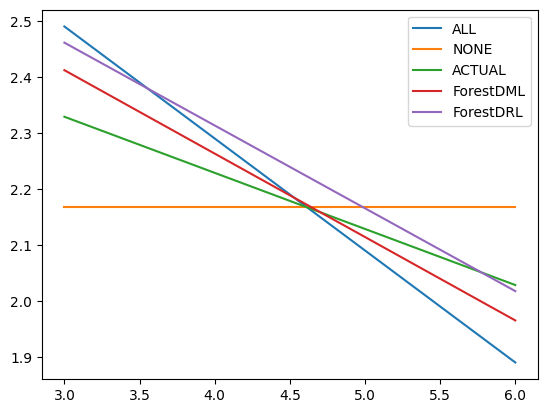

In [ ]:
# Plot data
plt.plot(res.T)
plt.legend(res.index)

Normally, we already have the cost of promotion, however, in case of unstable costs (e.g., change suppliers, high ad spend), the chart shows us when we should change the policy.   
- If the cost of promotion is less than or equal to 5% of the price (~ 1), we should apply DRL policy. Otherwise, we shouldn't offer promotions to anyone.
- If the cost is less than 3.5%, we should give offers to everyone.

Note: The cost is not related to the NONE policy so the revenue of the NONE policy does not change.


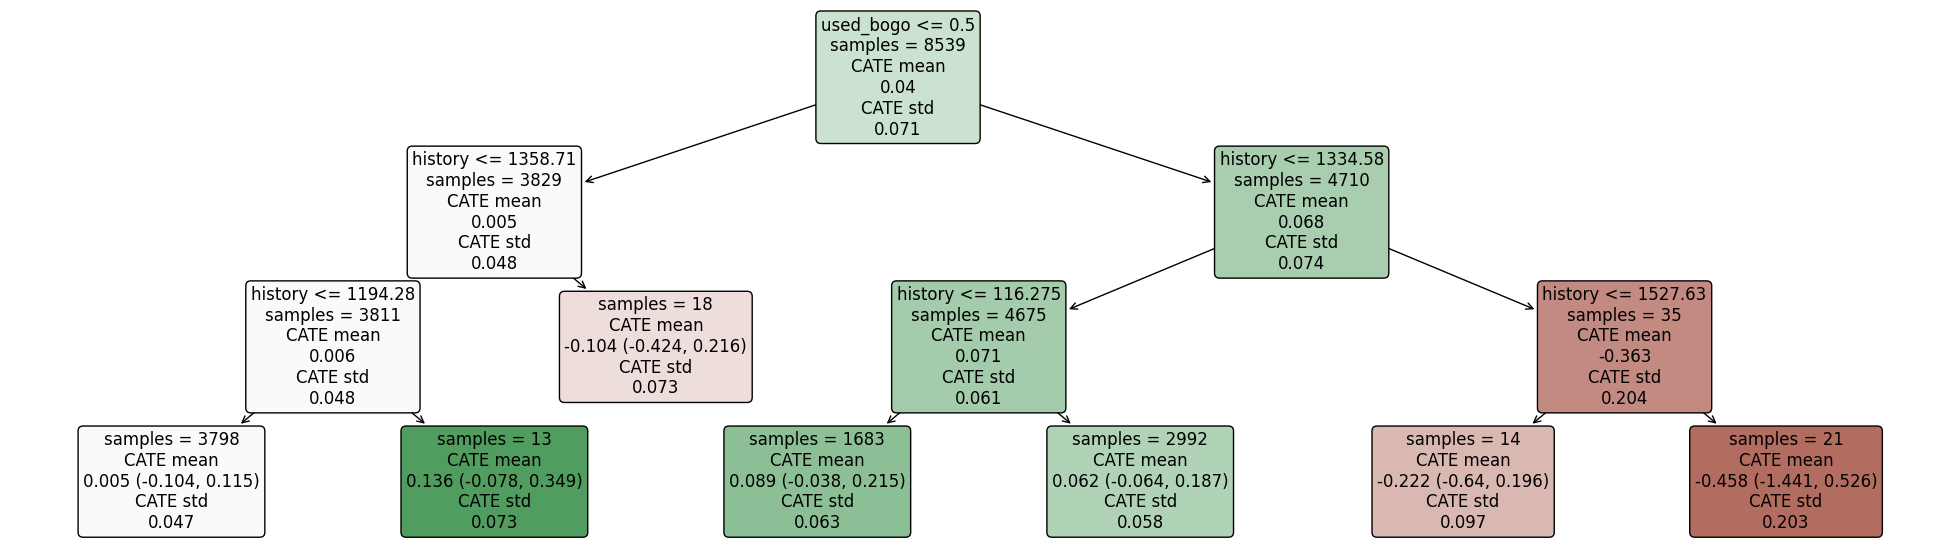

In [ ]:
# interpret with DRL estimation
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(est_dw_DRL, x_test)
plt.figure(figsize=(25, 7))
intrp.plot(feature_names=x.columns, fontsize=12)

Persons who have used the Buy One Get One promotion before and have bought less than or equal to 1334.58, will have a good response to the promotion.

# REFERENCES

https://econml.azurewebsites.net/index.html

https://github.com/py-why/EconML/tree/main/notebooks

https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html

https://www.youtube.com/watch?v=zQk13PVYMUs&list=PLoazKTcS0Rzb6bb9L508cyJ1z-U9iWkA0&index=46